In [240]:
import pandas as pd
import numpy as np
import math

import sklearn as skl
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [241]:
# validation function
def validate_model(model_type, param_grid, x_train, y_train, x_validate, y_validate):
    # Special case for LinearRegression because it doesn't have hyperparameters to tune
    if model_type == LinearRegression:
        model = LinearRegression()
        model.fit(x_train, y_train)
        pred = model.predict(x_validate)
        r2 = r2_score(y_validate, pred)
        
        return r2
    else: # The other cases
        
        # Establishses the ParameterGrid
        model_param_grid = ParameterGrid(param_grid)
        
        # Initialize values
        best_MAE = 0
        best_r2 = 1
        best_config = None
        # Iterate through the parameter grid, fit models to the hyperparameters
        # and check for MAE and R2 values
        
        # each param_config in that validation function would represent 1 combination of the possible parameters.
        # for example in Lab 6, when I'm validating for the elastic net regression, I have 
        # 2 possible hyperparameters: alpha and l1_ratio. 
        #alpha can take on values 0.0001, 0.0005, etc, and l1_ratio can take on values 0, 1, 0.01. 
        #So each param_config in the for loop in validate_model would go over 1 possible 
        #combination of the hyperparameter and keep the one that gives us the best MAE/R2
        for param_config in model_param_grid:
            curr_config_MAEs = []
            model = model_type(**param_config)
            model.fit(x_train, y_train)
            pred = model.predict(x_validate)
            MAE = mean_squared_error(y_validate,pred)
            r2 = r2_score(y_validate, pred)
            curr_config_MAEs.append(MAE)
            if best_MAE == 0 or (MAE < best_MAE):
                best_MAE = MAE
                best_config = param_config
            if best_r2 == 1 or (r2 > best_r2):
                best_r2 = r2
        return best_config, best_MAE, best_r2

In [242]:
# Predictions
def pred(model_type, x_train, y_train, x_test, y_test):
    # Fit model and predict 
    model = model_type.fit(x_train, y_train)
    pred = model.predict(x_test)
    
    # Format prediction as DataFrame
    pred_df = pd.DataFrame(pred, columns = ['RET_pred'])
    pred_df.set_index(x_test.index, inplace = True)
    
    r2 = r2_score(y_test, pred)
    return pred_df, r2

In [243]:
# Function to build the portfolio and calculate different performance metrics
def portfolio_build(df_pred, model_name, df_realized):
    # Get the year
    df_pred['yyyymm'] = vyear_extract(df_pred.index.values)
    df_pred.sort_values(by = 'yyyymm', inplace = True)
    
    # Initialize list of values
    long_short_lst = []
    value_lst = []
    
    # Iterate over years
    for time in df_pred['yyyymm'].unique():
        # Subset by year
        df_curr = df_pred[df_pred['yyyymm'] == time]
        # Sort the values by returns
        df_curr = df_curr.sort_values(by = ['RET_pred'], ascending = False)
        size = math.floor(df_curr.shape[0]/10)
        # Get the top/bottom performing stocks
        df_top = df_curr.head(size)
        df_bot = df_curr.tail(size)
        # Get the actual returns of the predicted top/bottom performers
        df_top_realized = df_realized.loc[df_top.index]
        df_bot_realized = df_realized.loc[df_bot.index]
        
    
        # Get the mean returns of these top/bottom performers
        mu_top = df_top_realized['RET'].mean()
        mu_bot = df_bot_realized['RET'].mean()
        
     
        # Get the mean returns by shorting the bottom and going long on the top
        long_short = (mu_top - mu_bot)
        
        value = df_top['value'].sum()
        value = value + df_bot['value'].sum()
        
        long_short_lst.append(long_short)
        value_lst.append(value)
    
    # Get the value for the portfolio
    ls_df = pd.DataFrame(long_short_lst, columns = ['ls_ret'], index = df_pred['yyyymm'].unique())
    ls_df['value'] = value_lst
    
    # Calculating cumulative returns
    # First we +1 to the returns 
    # Then we do the cumulative product
    ls_df['cumulative_ret']= ls_df['ls_ret'] + 1
    ls_df['cumulative_ret'] = ls_df['cumulative_ret'].cumprod()
    
    # Get mean/std/sharpe ratio for the portfolio
    ls_df = pd.merge(ls_df, rf_month, left_index = True, right_index = True)
    ls_df['ls_sub_rf'] = ls_df['ls_ret'] - ls_df['RF']
    ls_sub_rf_mean = ls_df['ls_sub_rf'].mean()*12
    ls_sub_rf_std = ls_df['ls_sub_rf'].std()*math.sqrt(12)
    sharpe_ratio = ls_sub_rf_mean/ls_sub_rf_std*math.sqrt(12)
    
    print("The annualized excess return "+ model_name + " long short portfolio is: " + str(ls_sub_rf_mean))
    print("The annualized std dev of returns of " + model_name + " long short portfolio is: " + str(ls_sub_rf_std))
    print("The anualized Sharpe ratio of " + model_name + " long short portfolio is: " + str(sharpe_ratio))
    
    return ls_df, ls_sub_rf_mean, ls_sub_rf_std, sharpe_ratio

In [244]:
# # importing the full dataframe from Lecture1_ML
# merged_df = pd.read_csv("merged_final.csv")

# # adding stock value as a column
# merged_df['value'] = merged_df['PRC'] * merged_df['VOL']

In [245]:
rf_month = pd.read_sas("dataset_files/ff_factors_monthly.sas7bdat")

rf_month['dateff'] = pd.to_datetime(rf_month['dateff'])
#rf_month = rf_month[rf_month['dateff']]
rf_month = rf_month[rf_month['dateff'].dt.year >= 1980]
rf_month = rf_month[['dateff', 'RF']]

def month_format(month):
    if len(month) == 1:
        month = str(0) + month
        return month
    else:
        return month

rf_month['year'] = rf_month['dateff'].apply(lambda x: str(x.year))
rf_month['month'] = rf_month['dateff'].apply(lambda x: str(x.month))
rf_month['month'] = rf_month['month'].apply(month_format)
rf_month['yyyymm'] = rf_month['year'] + rf_month['month']
rf_month['yyyymm'] = rf_month['yyyymm'].apply(lambda x: float(x))

rf_month = rf_month[['RF', 'yyyymm']]

In [246]:
# # adding risk free rate to merged_df
# merged_df = merged_df.merge(rf_month, on = ['yyyymm'])

# # setting index to permno-yyyymm
# merged_df['permno-yyyymm'] = merged_df['permno'].apply(lambda x: str(x)) + merged_df['yyyymm'].apply(lambda x: str(x)[:-2])
# merged_df['permno-yyyymm'] = merged_df['permno-yyyymm'].apply(lambda x: int(x))
# merged_df.set_index(merged_df['permno-yyyymm'], inplace = True)

# # dropping the permno-yyyymm column
# merged_df.drop(['permno-yyyymm'], axis= 1, inplace= True)
# #merged_df.drop(['Unnamed: 0'], axis= 1, inplace= True)

In [247]:
merged_df = pd.read_csv('dataset_files/merged_df.csv')

# adding stock value as a column
merged_df['value'] = merged_df['PRC'] * merged_df['VOL']

# setting index to permno-yyyymm
merged_df['permno-yyyymm'] = merged_df['permno'].apply(lambda x: str(x)) + merged_df['yyyymm'].apply(lambda x: str(x)[:-2])
merged_df['permno-yyyymm'] = merged_df['permno-yyyymm'].apply(lambda x: int(x))
merged_df.set_index(merged_df['permno-yyyymm'], inplace = True)

# dropping the permno-yyyymm column
merged_df.drop(['permno-yyyymm'], axis= 1, inplace= True)
#merged_df

In [345]:
# using a 60/20/20 split
train, validate, test = \
                        np.split(merged_df.sample(frac=1, random_state=301), 
                        [int(.50*len(merged_df))-1, int(.75*len(merged_df))])

#factors = list(train.columns[9:41])
#factors = ['lag_log_size', 'dp', 'roe', 'O_SCORE_Q', 'pe_ttm', 'INVESTMENT_GROWTH_3Y', 'RSI_20']
factors = ['lag_log_size', 'roe', 'O_SCORE_Q', 'pe_ttm', 'INVESTMENT_GROWTH_3Y', 'deviation_pct20']

x_train = train[factors]
y_train = train['RET']
#y_train = train['ret_f1']

x_validate = validate[factors]
y_validate = validate['RET']
#y_validate = validate['ret_f1']

x_test = test[factors]
y_test = test['RET']
#y_test = test['ret_f1']

In [346]:
# Initialize the dictionary for the parameter grid
en_grid = dict()
# Set the parameter grid
en_grid['alpha'] = [0.0001,0.0005,0.001,0.005, 0.01,0.05,0.1]
en_grid['l1_ratio'] = np.arange(0, 1, 0.01)

# Run the validation
en_best_config, en_best_MAE, en_best_r2 = validate_model(ElasticNet, en_grid, x_train, y_train, x_validate\
                                                         , y_validate)

# To avoid convergence warnings, we can either 
# 1) set the tolerance higher (to require a less strict convergence requirement) or
# 2) increase the maximum number of iterations we allow

# There is no guarantee that we will get convergence when we fit a model, we can only 
# decide to cut off after a certain point

print('Best Config' + str(en_best_config))
print('Validation R2: '+ str(en_best_r2))

C:\Users\Andrew\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e+03, tolerance: 2.125e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Andrew\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+03, tolerance: 2.125e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

Best Config{'alpha': 0.0001, 'l1_ratio': 0.0}
Validation R2: 0.003274561441191315


In [347]:
pls_grid = dict()
pls_grid['n_components'] = np.arange(1, len(factors)+1, 1)

pls_best_config, pls_best_MAE, pls_best_r2 = validate_model(PLSRegression, pls_grid, x_train, y_train, x_validate\
                                                            , y_validate)
print('Best config:' + str(pls_best_config))
print('Validation R2: ' + str(pls_best_r2))

Best config:{'n_components': 1}
Validation R2: 0.003370069123728281


In [348]:
print(en_best_config['l1_ratio'])

0.0


In [349]:
# Run the validation for the Linaer Regression
slr_r2_score = validate_model(LinearRegression, 1, x_train, y_train, x_validate, y_validate)

In [350]:
slr_vali_pred_df, slr_vali_r2 = pred(LinearRegression(), x_train, y_train, x_validate, y_validate)
en_vali_pred_df, en_vali_r2 = pred(ElasticNet(l1_ratio = en_best_config['l1_ratio'], alpha = en_best_config['alpha']),\
                                     x_train, y_train, x_validate, y_validate)
pls_vali_pred_df, pls_vali_r2 = pred(PLSRegression(pls_best_config['n_components']), x_train, y_train, x_validate, y_validate)

C:\Users\Andrew\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e+03, tolerance: 2.125e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'Actual returns vs predicted returns (validation set), SLR')

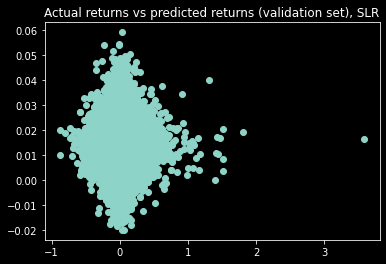

In [351]:
plt.scatter(y_test.sort_index(), slr_vali_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs predicted returns (validation set), SLR')

Text(0.5, 1.0, 'Actual returns vs predicted returns (validation set), PLS')

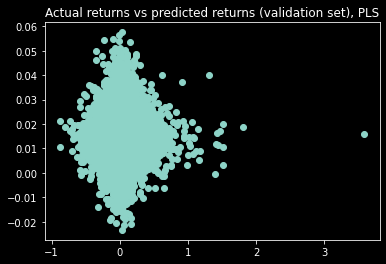

In [352]:
plt.scatter(y_test.sort_index(), pls_vali_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs predicted returns (validation set), PLS')

Text(0.5, 1.0, 'Actual returns vs predicted returns (validation set), EN')

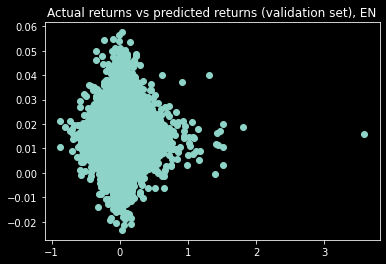

In [353]:
plt.scatter(y_test.sort_index(), pls_vali_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs predicted returns (validation set), EN')

In [354]:
# Get the predictions for each model (using hyperparameters from validation)
slr_pred_df, slr_test_r2 = pred(LinearRegression(), x_train, y_train, x_test, y_test)
en_pred_df, en_test_r2 = pred(ElasticNet(l1_ratio = en_best_config['l1_ratio'], alpha = en_best_config['alpha']), x_train, y_train, x_test, y_test)
pls_pred_df, pls_test_r2 = pred(PLSRegression(pls_best_config['n_components']), x_train, y_train, x_test, y_test)

C:\Users\Andrew\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.059e+03, tolerance: 2.125e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [355]:
# extracts year from index
def year_extract(index):
    return int(str(index)[5:])

# vectorizes the function
vyear_extract = np.vectorize(year_extract)

In [356]:
# Setting rf_month index to match ls_df later
rf_month['yyyymm'] = rf_month['yyyymm'].apply(lambda x: int(str(x)[:6]))
rf_month.set_index(rf_month['yyyymm'], inplace= True)

In [357]:
# adds the stock values to the predicted DataFrames
slr_pred_df = pd.merge(slr_pred_df, merged_df['value'], left_index=True, right_index=True)
en_pred_df = pd.merge(en_pred_df, merged_df['value'], left_index=True, right_index=True)
pls_pred_df = pd.merge(pls_pred_df, merged_df['value'], left_index=True, right_index=True)

In [358]:
# Build portfolio
slr_ls_df, slr_ls_sub_rf_mean, slr_ls_sub_rf_std, slr_sharpe_ratio = portfolio_build(slr_pred_df, "SLR", merged_df)
en_ls_df, en_ls_sub_rf_mean, en_ls_sub_rf_std, en_sharpe_ratio = portfolio_build(en_pred_df, "EN", merged_df)
pls_ls_df, pls_ls_sub_rf_mean, pls_ls_sub_rf_std, pls_sharpe_ratio = portfolio_build(pls_pred_df, "PLS", merged_df)

The annualized excess return SLR long short portfolio is: 0.19264572071249358
The annualized std dev of returns of SLR long short portfolio is: 0.19618614367905207
The anualized Sharpe ratio of SLR long short portfolio is: 3.4015875930629345
The annualized excess return EN long short portfolio is: 0.19182430272788303
The annualized std dev of returns of EN long short portfolio is: 0.1954729196724926
The anualized Sharpe ratio of EN long short portfolio is: 3.3994421222933364
The annualized excess return PLS long short portfolio is: 0.18724803654402816
The annualized std dev of returns of PLS long short portfolio is: 0.1989146483865604
The anualized Sharpe ratio of PLS long short portfolio is: 3.2609273931550575


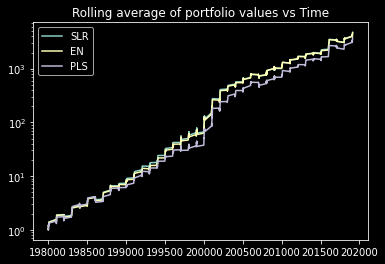

In [359]:
# Plot Rolling value
plt.plot(slr_ls_df.index, slr_ls_df['cumulative_ret'], label = 'SLR')
plt.plot(en_ls_df.index, en_ls_df['cumulative_ret'], label = 'EN')
plt.plot(pls_ls_df.index, pls_ls_df['cumulative_ret'], label = 'PLS')

plt.yscale('log')
plt.legend()
plt.title("Rolling average of portfolio values vs Time")
    
plt.show()

Text(0.5, 1.0, 'Actual returns vs test set predicted returns (test set), SLR')

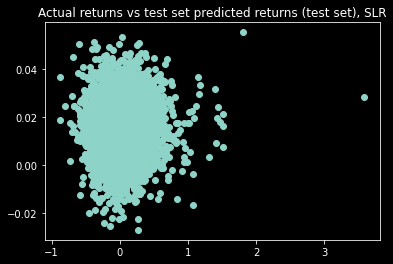

In [360]:
plt.scatter(y_test.sort_index(), slr_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs test set predicted returns (test set), SLR')

Text(0.5, 1.0, 'Actual returns vs predicted returns (test set), PLS')

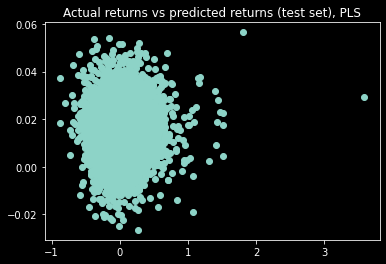

In [361]:
plt.scatter(y_test.sort_index(), pls_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs predicted returns (test set), PLS')

Text(0.5, 1.0, 'Actual returns vs predicted returns (test set), EN')

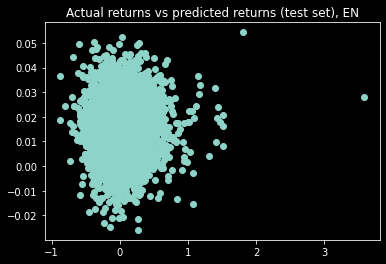

In [362]:
plt.scatter(y_test.sort_index(), en_pred_df['RET_pred'].sort_index())
plt.title('Actual returns vs predicted returns (test set), EN')

In [363]:
# Tabulate
from tabulate import tabulate

table = [['Type', 'Avg Ret', 'Std. Dev', 'SR', 'R^2'],\
         ['SLR', slr_ls_sub_rf_mean, slr_ls_sub_rf_std, slr_sharpe_ratio, slr_r2_score],
         ['EN', en_ls_sub_rf_mean, en_ls_sub_rf_std, en_sharpe_ratio, en_best_r2],
         ['PLS', pls_ls_sub_rf_mean, pls_ls_sub_rf_std, pls_sharpe_ratio, pls_best_r2]]
print(tabulate(table, headers='firstrow'))

Type      Avg Ret    Std. Dev       SR         R^2
------  ---------  ----------  -------  ----------
SLR      0.192646    0.196186  3.40159  0.00329196
EN       0.191824    0.195473  3.39944  0.00327456
PLS      0.187248    0.198915  3.26093  0.00337007


In [364]:
# Export results for later use
data = [['SLR', slr_ls_sub_rf_mean, slr_ls_sub_rf_std, slr_sharpe_ratio, slr_r2_score],
        ['EN', en_ls_sub_rf_mean, en_ls_sub_rf_std, en_sharpe_ratio, en_best_r2],
        ['PLS', pls_ls_sub_rf_mean, pls_ls_sub_rf_std, pls_sharpe_ratio, pls_best_r2]]
results = pd.DataFrame(data, columns= ['Type', 'Avg Ret', 'Std. Dev', 'SR', 'R^2'])

rol_val = pd.concat([slr_ls_df['cumulative_ret'], en_ls_df['cumulative_ret'], pls_ls_df['cumulative_ret']],\
                    axis = 1)
rol_val.columns = ['slr_cum_ret', 'en_cum_ret', 'pls_cum_ret']

results.to_csv("ml_output_files/finalproject_metrics.csv")
rol_val.to_csv("ml_output_files/finalproject_values.csv")

# exporting the ls_df for each model
slr_ls_df.to_csv("ml_output_files/slr_ls_df.csv")
pls_ls_df.to_csv("ml_output_files/pls_ls_df.csv")
en_ls_df.to_csv("ml_output_files/en_ls_df.csv")